# Estimating COVID-19's $R_t$ in Real-Time 

This notebook reproduces the estimate of the time-varying reproductive number $R_t$ implemented by [Kevin Systrom](https://twitter.com/kevin) available [here](https://github.com/k-sys/covid-19).

I am applying the same code to the UK case data, with minor changes:

 - a different assumed average serial interval (5 days)
 - a shift of 7 days of the time-series to take into account the reporting delays

For clarity, I have removed all the text from the original notebook, which describes the theory behind the method.

The modelling implemented by Kevin is largely based on [this 2008 Epidemiology paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185)

First, let's import the libraries required.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'

In [4]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


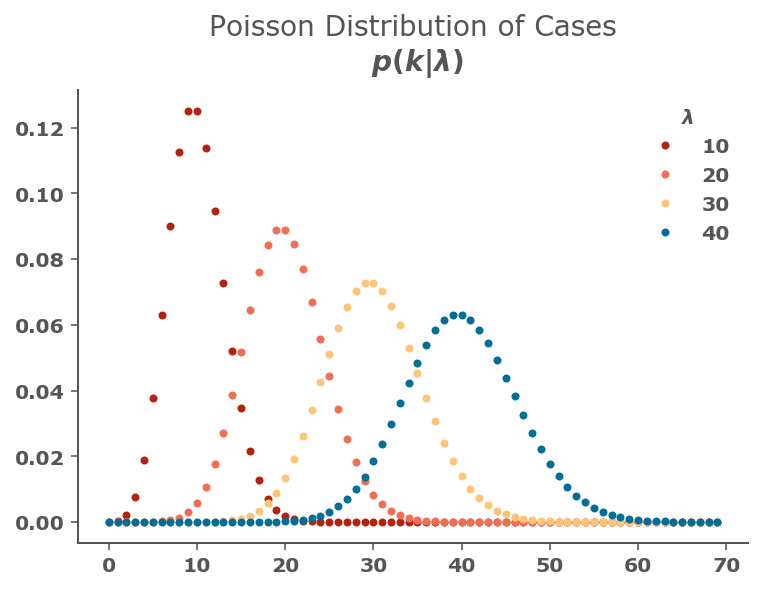

In [8]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

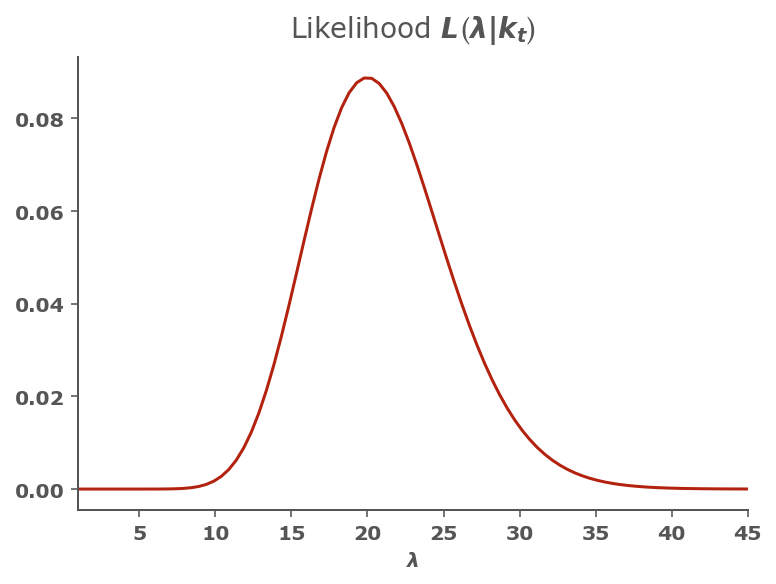

In [9]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$');

# Parameters
Here we will limit $R_T$ to a maximum of 8. <br>
We will assume that an average serial interval of 5 days as per UK estimates.

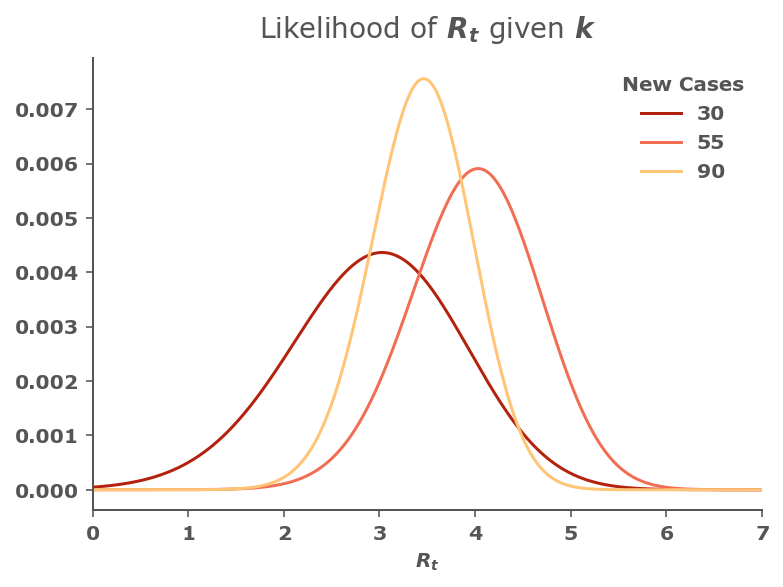

In [15]:
k = np.array([20, 30, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 8
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
GAMMA = 1/5

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,7)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

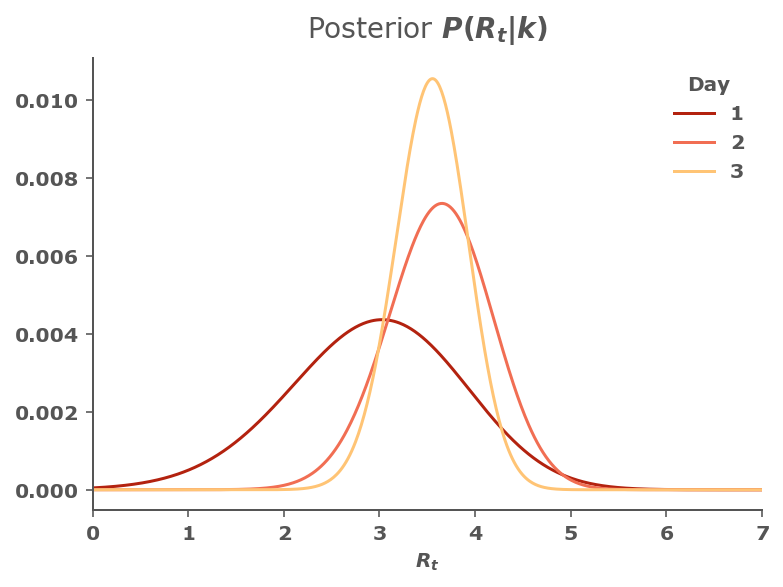

In [16]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,7)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [19]:
most_likely_values = posteriors.idxmax(axis=0)
print(most_likely_values)

Day
1    3.03
2    3.65
3    3.55
dtype: float64


In [ ]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)
print(hdi)

# Real-World Application to UK Data
## Setup
Load in UK data from [here](https://raw.githubusercontent.com/traffordDataLab/covid-19/master/).

In [67]:
states = pd.read_csv('UK_cases.csv', 
                     usecols=[0,2],
                     index_col=['data'],
                     parse_dates=['data'],
                     squeeze=True).sort_index()

states

data
2020-01-31         2
2020-02-01         2
2020-02-02         2
2020-02-03         2
2020-02-04         2
               ...  
2020-04-12     84279
2020-04-13     88621
2020-04-14     93873
2020-04-15     98476
2020-04-16    103093
Name: CumCases, Length: 77, dtype: int64

# Time shift to account for the reporting delay
We add a constant offset to the case notification data of 7 days to take into account the delay from contagion to reporting. This is clearly a very rough assumption and other statistical methods to assign a date of infection to all cases would provide a better estimate.

In [68]:
states=states.tshift(-7, freq='D')
state_name = 'United Kingdom'


In [69]:
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

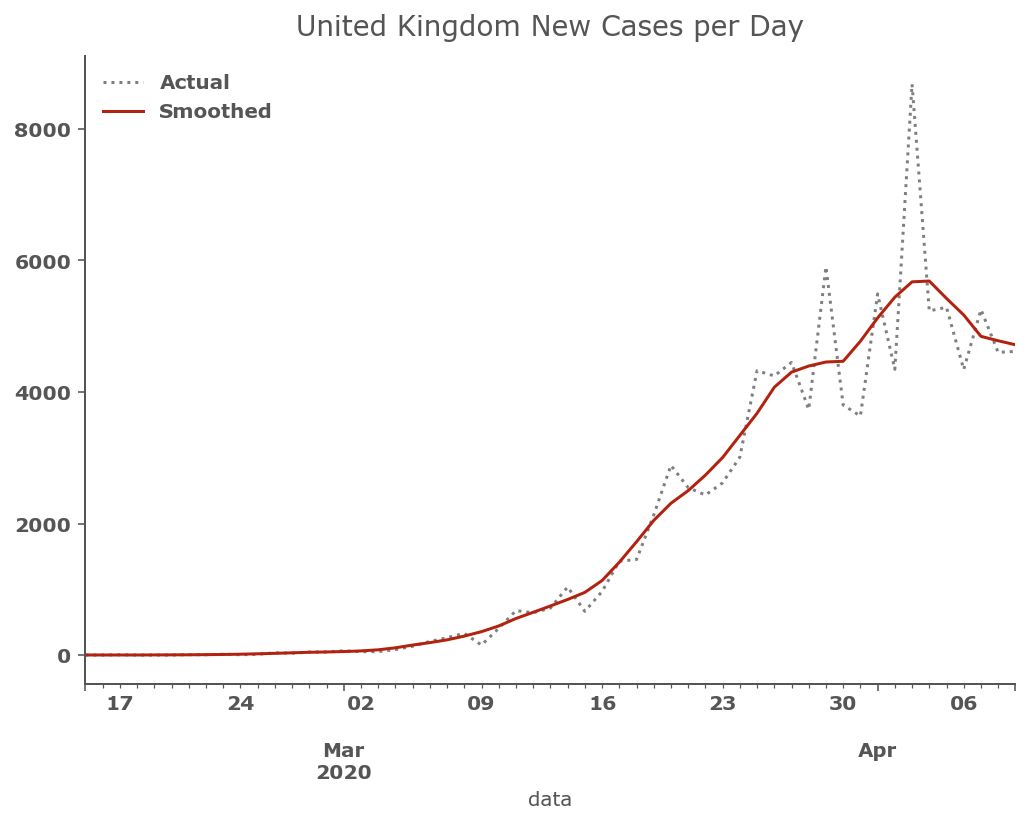

In [70]:
cases = states.rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

In [71]:
def get_posteriors(sr, window=7, min_periods=1):
    
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

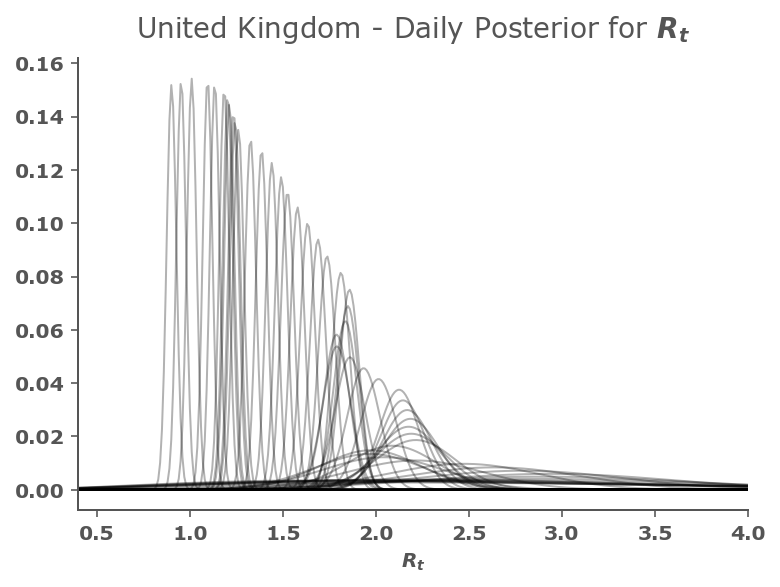

In [72]:

ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

In [73]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
data,,,
2020-04-05,1.13,1.08,1.19
2020-04-06,1.10,1.04,1.15
2020-04-07,1.01,0.96,1.07
2020-04-08,0.95,0.90,1.01
2020-04-09,0.90,0.85,0.96


In [74]:
today=str(pd.to_datetime('today').date())

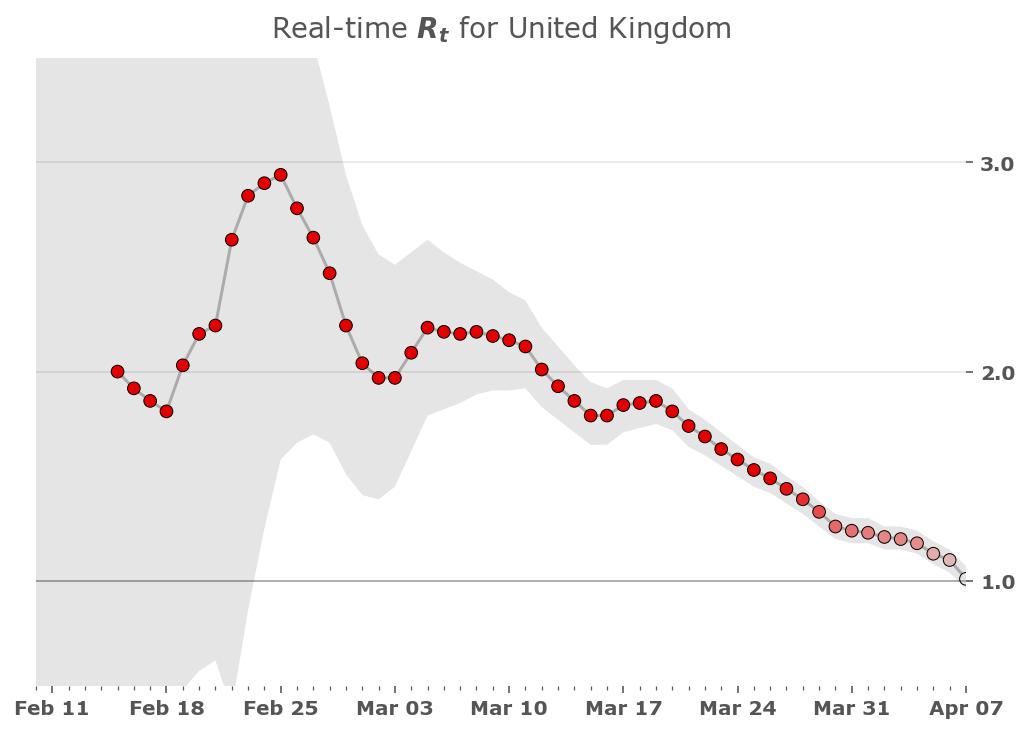

In [77]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    #ax.axvline('2020-02-24', ls='--', color='coral', lw=1.5, zorder=0)
    #ax.axvline('2020-03-08', ls='--', color='orange', lw=1.5, zorder=0)
    #ax.axvline('2020-03-12', ls='--', color='red', lw=1.5, zorder=0)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                    result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                     result['High'].values,
                     bounds_error=False,
                    fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-10'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-02-10'), result[:-3].index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
